In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# create element tree object 
tree = ET.parse('./export.xml') 

# for every health record, extract the attributes into a dictionary (columns). Then create a list (rows).
root = tree.getroot()
record_list = [x.attrib for x in root.iter('Record')]

# create DataFrame from a list (rows) of dictionaries (columns)
data = pd.DataFrame(record_list)

# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    data[col] = pd.to_datetime(data[col])

# value is numeric, NaN if fails
data['value'] = pd.to_numeric(data['value'], errors='coerce')

# some records do not measure anything, just count occurences
# filling with 1.0 (= one time) makes it easier to aggregate
data['value'] = data['value'].fillna(1.0)

# shorter observation names: use vectorized replace function
data['type'] = data['type'].str.replace('HKQuantityTypeIdentifier', '')
data['type'] = data['type'].str.replace('HKCategoryTypeIdentifier', '')

In [2]:
pivot_df = data.pivot_table(index='endDate', columns='type', values='value')
df = pivot_df.resample('5min').mean()
ml_df = pd.merge_asof(
    df[df.columns[15:17]].dropna(),
    df['BloodGlucose'].dropna(),
    left_index=True,
    right_index=True,
    direction="nearest",
)
x=ml_df[ml_df.columns[0:2]]
y_not_filtered=ml_df[ml_df.columns[2:3]]

In [3]:
y = pd.DataFrame()
y['BloodGlucose'] = ["NOTDESIRED" if value < 3.5 else "DESIRED" for value in y_not_filtered["BloodGlucose"]]
y.value_counts()=="NOTDESIRED"

BloodGlucose
DESIRED         False
NOTDESIRED      False
dtype: bool

In [4]:
class_weight = 'balanced'
np.unique(y["BloodGlucose"])


array(['DESIRED', 'NOTDESIRED'], dtype=object)

In [5]:
from sklearn import preprocessing
from pandas import DataFrame
from sklearn.utils.validation import column_or_1d
from sklearn import preprocessing

from sklearn.model_selection import *
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings("ignore")

y = column_or_1d(y, warn=False)
label_encoder = preprocessing.LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
list(label_encoder.classes_)
# over = SMOTE(sampling_strategy=0.5)
# under = RandomUnderSampler(sampling_strategy=0.5)

['DESIRED', 'NOTDESIRED']

In [6]:

# DataFrame(y_encoded).describe()
# y_encoded

In [7]:
x

HeartRate  HeartRateVariabilitySDNN
endDate                                                       
2021-12-20 12:20:00+03:00  59.258198                   58.3717
2021-12-20 15:15:00+03:00  71.536346                   80.7055
2021-12-20 15:55:00+03:00  51.331150                   67.4926
2021-12-20 16:00:00+03:00  49.814300                   67.1677
2021-12-20 16:45:00+03:00  62.452567                   89.7570
...                              ...                       ...
2022-04-28 18:10:00+03:00  59.301400                   40.9687
2022-04-29 13:30:00+03:00  65.786400                   71.4751
2022-04-29 20:15:00+03:00  83.569500                   73.2705
2022-04-29 21:50:00+03:00  74.984750                   75.2658
2022-04-30 00:25:00+03:00  96.696000                   16.0575

[728 rows x 2 columns]

In [8]:
# x.to_csv("data_2.csv", index=False)

In [9]:

# parameters_svc = {
#         "svc__C": [ 0.0001, 0.001, 0.01, 1, 10],
#         'svc__kernel':['poly', 'linear'],
#         'svc__degree':[3,5,7],
#         'svc__probability':[True, False],
#         'svc__shrinking':[True, False],
#         'svc__tol':[ 0.1, 1, 2]
#         }

# pipeline_svc = Pipeline([
#         # ('o', over), 
#         # ('u', under),
#         ('scaler', RobustScaler()),
#         ('svc', SVC(class_weight=class_weight))
#     ])
# clf_svc = GridSearchCV(pipeline_svc, parameters_svc, 
#                    cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=42),
#                    scoring='roc_auc',
#                    verbose=0,
#                    n_jobs=-1,
                   
#                    )

# clf_svc.fit(x, y_encoded)

In [10]:
# print ('Best parameters:', clf_svc.best_params_)
# print ('Best estimator:', clf_svc.best_estimator_)
# print ('Best score:', clf_svc.best_score_)


In [11]:

# parameters_xgb = {
#         'xgb__max_depth': range (1, 5, 1),
#         'xgb__n_estimators': [1,2,3],
#         'xgb__min_child_weight': np.arange(0, 5, 1).tolist(),
#         'xgb__scale_pos_weight': [4.0],
#         'xgb__alpha': [1],
#         'xgb__lambda': np.arange(0, 1.0, 0.1).tolist(),
#         'xgb__gamma': [ 3,4,5],
#         'xgb__booster': ['gbtree',  'dart'],
#         'xgb__eta': np.arange(0.1, 1.0, 0.1).tolist(),
#         'xgb__subsample': np.arange(0.1, 1.0, 0.1).tolist(),
#         'xgb__max_delta_step': [1,2,3]
#         }


# pipeline_xgb = Pipeline([
#         # ('o', over), 
#         # ('u', under),
#         ('scaler', RobustScaler()),
#         ('xgb', XGBClassifier(verbosity = 0, silent=True))
#     ])
# clf_xgb = GridSearchCV(pipeline_xgb, parameters_xgb,
#                    cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=42), 
#                    scoring='roc_auc',
#                    verbose=0,
#                    n_jobs=-1
#                    )

# clf_xgb.fit(x, y_encoded)

In [12]:
# print ('Best parameters:', clf_xgb.best_params_)
# print ('Best estimator:', clf_xgb.best_estimator_)
# print ('Best score:', clf_xgb.best_score_)

In [13]:

# parameters_rfc = {
#             'rfs__n_estimators': [1, 3, 5],
#             'rfs__max_features': ['auto', 'sqrt', 'log2'] ,
#             'rfs__max_depth' : range (1, 5, 1),
#             'rfs__min_samples_split':[2,3,4], 
#             'rfs__min_samples_leaf':[0.1, 0.25,0.5], 
#             'rfs__bootstrap' : [True, False],
#             'rfs__criterion':['gini', 'entropy'],
#             'rfs__class_weight':[None, 'balanced']
#         }

# pipeline_rfc = Pipeline([
#         # ('o', over), 
#         # ('u', under),
#         ('scaler', RobustScaler()),
#         ('rfs', RandomForestClassifier(class_weight=class_weight))
#     ])
# clf_rfc = GridSearchCV(pipeline_rfc, parameters_rfc, 
#                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
#                    scoring='roc_auc',
#                    verbose=0,
#                    n_jobs=-1
#                    )

# clf_rfc.fit(x, y_encoded)

In [14]:
# print ('Best parameters:', clf_rfc.best_params_)
# print ('Best estimator:', clf_rfc.best_estimator_)
# print ('Best score:', clf_rfc.best_score_)

In [15]:
# from joblib import dump, load
# dump(clf_svc, f'clf_svc_{clf_svc.best_score_}.joblib') 


# dump(clf_svc.best_estimator_, f'best_estimator_model_{clf_svc.best_score_}.pkl')

In [16]:
# clf_svc.best_estimator_.predict(x)

In [17]:
# from joblib import dump, load
# dump(clf_xgb, f'clf_xgb_{clf_xgb.best_score_}.joblib') 


# dump(clf_xgb.best_estimator_, f'best_estimator_model_xgb_{clf_xgb.best_score_}.pkl')
import warnings
warnings.filterwarnings("ignore")

In [18]:
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
warnings.filterwarnings("ignore")
# poly = PolynomialFeatures(degree=2, interaction_only=True)
# x_new = poly.fit_transform(x)
parameters_sgc = {
        # "svc__C": [ 10],
        # "svc__gamma": [2]
        }

pipeline_sgc = Pipeline([
        # ('o', over), 
        # ('u', under),
        # ('scaler', RobustScaler()),
        ('svc',QuadraticDiscriminantAnalysis())
    ])
clf_sgc = GridSearchCV(pipeline_sgc, parameters_sgc,
                   cv=StratifiedKFold(n_splits=7, shuffle=True, random_state=42), 
                   scoring='f1',
                   verbose=0,
                   n_jobs=-1
                   )
clf_sgc.fit(x, y_encoded)


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('svc',
                                        QuadraticDiscriminantAnalysis())]),
             n_jobs=-1, param_grid={}, scoring='f1')

In [19]:
print ('Best parameters:', clf_sgc.best_params_)
print ('Best estimator:', clf_sgc.best_estimator_)
print ('Best score:', clf_sgc.best_score_)


Best parameters: {}
Best estimator: Pipeline(steps=[('svc', QuadraticDiscriminantAnalysis())])
Best score: 0.0


In [20]:
from joblib import dump, load
dump(clf_sgc, f'clf_sgc_{clf_sgc.best_score_}.joblib') 


dump(clf_sgc.best_estimator_, f'best_estimator_model_{clf_sgc.best_score_}_sgc.pkl')

['best_estimator_model_0.0_sgc.pkl']

In [21]:
y_predicted = clf_sgc.best_estimator_.predict(x)

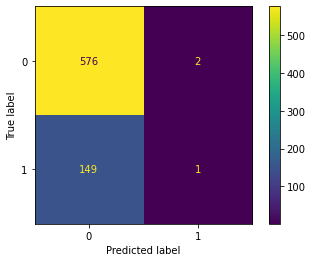

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_encoded,y_predicted,labels=clf_sgc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_sgc.classes_)
disp.plot()

plt.show()


In [23]:
x

HeartRate  HeartRateVariabilitySDNN
endDate                                                       
2021-12-20 12:20:00+03:00  59.258198                   58.3717
2021-12-20 15:15:00+03:00  71.536346                   80.7055
2021-12-20 15:55:00+03:00  51.331150                   67.4926
2021-12-20 16:00:00+03:00  49.814300                   67.1677
2021-12-20 16:45:00+03:00  62.452567                   89.7570
...                              ...                       ...
2022-04-28 18:10:00+03:00  59.301400                   40.9687
2022-04-29 13:30:00+03:00  65.786400                   71.4751
2022-04-29 20:15:00+03:00  83.569500                   73.2705
2022-04-29 21:50:00+03:00  74.984750                   75.2658
2022-04-30 00:25:00+03:00  96.696000                   16.0575

[728 rows x 2 columns]